In [34]:
%matplotlib inline
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [35]:
# Initialize the library.
ee.Initialize()

## Configuration

In [36]:
LABEL_DICT = {'built': 6, 'water': 0, 'tree': 1, 'grass': 2, 'flooded_veg': 3, 'crop': 4, 
             'shrub': 5, 'bare': 7, 'snow': 8}
COLOR_DICT = {'built': '#C4281B', 'water': '#419BDF', 'tree': '#397D49', 'grass': '#88B053', 
              'flooded_veg': '#7A87C6', 'crop': '#E49635', 
             'shrub': '#DFC35A', 'bare': '#A59B8F'}#, 'snow': '#B39FE1'}

In [37]:
csv_file = 'DBR_Excel_data_pro.csv'

## Load bridge info

In [38]:
df = pd.read_csv(csv_file)

In [39]:
df.head()

,Unnamed: 0,S.No,Bridge_No,Bridge_Name,Bridge_Type,Bridge_Span,River_Name,Trail_Type,District,Major_VDC,...,State,Ward_No,Latitude,Longitude,Const_Year,Local_Fund,Foreign_Agency,Bridge Condition,start_year,end_year
0,0,1,01 5 002 18 06 01,Jogi Rumba,D,50,Sobuwa khola,Local,Taplejung,Hangdewa,...,1,NaN,27.377915,87.697766,2005/06,VDC,SDC,No action required,2005,2006
1,1,2,01 5 002 18 06 02,Dhupaure,ST,32,Dhupaure Khola,Local,Taplejung,Hangdewa,...,1,NaN,27.364250,87.708946,1999/2000,Other,KAABGN,No action required,1999,2000
2,2,3,01 5 003 18 06 04,Mauwa Khola,D,60.5,Mauwa Khola,Main,Taplejung,Phuurumbu,...,1,NaN,27.413410,87.720686,2004/05,Other,KAABGN,No action required,2004,2005
3,3,4,01 5 003 18 06 05,Gopani,D,50,Gopani Khola,Local,Taplejung,Phuurumbu,...,1,NaN,27.398313,87.731395,2007/08,VDC,DRILP+SDC/DFID,No action required,2007,2008
4,4,5,01 5 004 18 06 01,Thouwa,D,37,Sisne Khola,Local,Taplejung,Limkhim,...,1,NaN,27.428107,87.713575,1998/99,VDC,SDC,No action required,1998,1999


take one bridge as example

In [40]:
df.loc[6100]

Unnamed: 0                         7917
S.No                               7918
Bridge_No            03 5 0181 18 06 03
Bridge_Name           Chanaute BadhBesi
Bridge_Type                           D
Bridge_Span                        83.1
River_Name                 Chauri Khola
Trail_Type                         Main
District                Kabhrepalanchok
Major_VDC           Chaurideurali Ga Pa
Major Palika        Chaurideurali Ga Pa
State                                 0
Ward_No                               1
Latitude                      27.524839
Longitude                     85.817489
Const_Year                    2019/2020
Local_Fund                          VDC
Foreign_Agency                     SWAp
Bridge Condition     No action required
start_year                         2019
end_year                           2020
Name: 6100, dtype: object

In [41]:
bridge = df.loc[6100]

## Convert/download class map as array

* randomly pick one dynamic world fullfill the filter criterias
* return its class map as array (for further analysis & visualization)

In [42]:
def getArray(lon, lat, year, distance=1000):
    # creat point
    point = ee.Geometry.Point(lon, lat)
    
    # creat buffer as geometry
    geometry = point.buffer(distance=distance)
    
    # define time range (annual)
    startDate = '{}-01-01'.format(year)
    endDate = '{}-01-01'.format(int(year)+1)
    
    # select S2 and corresponding DW
    s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterDate(startDate, 
                            endDate).filterBounds(geometry).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))
    s2Image = ee.Image(s2.first())
    imageId = s2Image.get('system:index').getInfo()
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.eq('system:index', imageId))
    dwImage = ee.Image(dw.first())
    classification = dwImage.select('label')
    
    # convert to np.array
    rgb_img = geemap.ee_to_numpy(classification, region=geometry)
    print(rgb_img.shape)
    
    # visualize
    plt.imshow(rgb_img)
    plt.title('Image {} for bridge built on year {} at ({}, {})'.format(imageId, year, lon, lat))
    plt.show()
    
    return rgb_img

In [43]:
lat, lon = bridge['Latitude'], bridge['Longitude']
start_year, end_year = bridge['start_year'], bridge['end_year']

print(start_year, end_year)

2019 2020


(201, 200, 1)


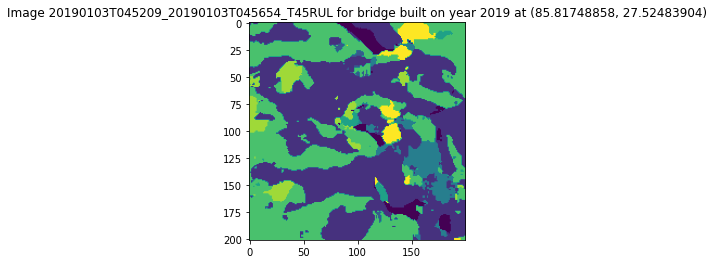

In [44]:
rgb_img_before = getArray(lon, lat, start_year)

(201, 200, 1)


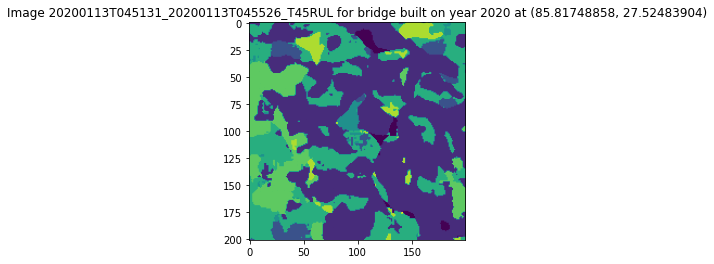

In [45]:
rgb_img_after = getArray(lon, lat, start_year+1)

## Visualization of transition

In [52]:
source = rgb_img_before.reshape((-1, ))
target = rgb_img_after.reshape((-1, ))
weight = np.ones(source.shape)
# summarize in a df
d = {'source': source, 'target': target}
trans = pd.DataFrame(data=d)

In [53]:
df_vis = pd.DataFrame(columns = ['source', 'target', 'weight'])
lookup = {value: key for key, value in LABEL_DICT.items()}
# calculate flow volume from trans df
for s in range(8):
    sname = lookup[s]
    for t in range(s+1, 8):
        tname = lookup[t]
        volume = len(trans[(trans['source'] ==s) & (trans['target'] ==t)])
        df_vis.loc[-1] = [sname, tname, volume]
        df_vis.index = df_vis.index + 1
        df_vis = df_vis.sort_index()
#         print('# pixels of {} -> {} = {}'.format(s, t, volume))

In [55]:
from d3blocks import D3Blocks
# Initialize
d3 = D3Blocks(chart='Chord', frame=False)
#
# Node properties
d3.set_node_properties(df_vis, color='source', opacity=0.2, cmap='tab20')
d3.set_edge_properties(df_vis, color='source', opacity=0.5)
# Show the chart
d3.show(fontsize=20, filepath='vis.html')

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Convert to Dictionary.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Set [fontsize]: 20
[d3blocks] >INFO> Set [filepath]: vis.html
[d3blocks] >INFO> File already exists and will be overwritten: [vis.html]


## Visualize before-after comparison


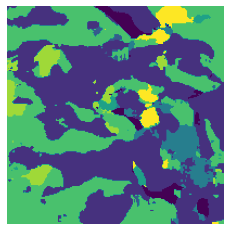
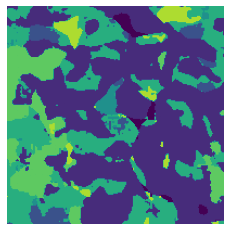

In [50]:
%%compare  --height 400
from skimage import data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

plt.imshow(rgb_img_before)
plt.axis("off")
plt.show()

plt.imshow(rgb_img_after)
plt.axis("off")
plt.show()